In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np

%pip install matplotlib tqdm
%matplotlib inline

import matplotlib.pyplot as plt
from tqdm import tqdm
import math

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Note: you may need to restart the kernel to use updated packages.
Using device: cuda


In [2]:
# Get setup info

print(f"PyTorch Version: {torch.__version__}")

if torch.cuda.is_available():
    print("-" * 30)
    print(f"CUDA Version: {torch.version.cuda}")

for i in range(torch.cuda.device_count()):
    # Calculate VRAM in GB
    vram_gb = torch.cuda.get_device_properties(i).total_memory / 1024**3
    
    print("-" * 30)
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    # Use the calculated variable here
    print(f"VRAM: {vram_gb:.2f} GB")

PyTorch Version: 2.8.0+cu128
------------------------------
CUDA Version: 12.8
------------------------------
GPU 0: NVIDIA GeForce RTX 5090
VRAM: 31.37 GB


### Estimate ideal loss on the dataset a priori

Use strong compression algorithm to estimated the theoretical loss lower bound:

$$\text{Ideal Loss} \approx \frac{\text{Compressed Bits}}{N} \times \ln(2)$$

In [3]:
# define a sinple BPE tokenizer
import re
from collections import Counter
import json

class SimpleBPE:
    """
    Simple Byte Pair Encoding tokenizer.
    Trains custom vocabulary on your text data.
    """

    def __init__(self):
        self.vocab = {}           # token_id -> token_string
        self.vocab_inv = {}       # token_string -> token_id
        self.merges = []          # list of merge rules
        self.special_tokens = {}
        self.max_token_len = 1    # for fast encoding

    def _get_stats(self, token_seqs):
        """Count frequency of adjacent pairs."""
        pairs = Counter()
        for seq in token_seqs:
            for i in range(len(seq) - 1):
                pairs[(seq[i], seq[i + 1])] += 1
        return pairs

    def _merge_pair(self, token_seqs, pair, new_token):
        """Merge all occurrences of pair into new_token."""
        new_seqs = []
        for seq in token_seqs:
            new_seq = []
            i = 0
            while i < len(seq):
                if i < len(seq) - 1 and seq[i] == pair[0] and seq[i + 1] == pair[1]:
                    new_seq.append(new_token)
                    i += 2
                else:
                    new_seq.append(seq[i])
                    i += 1
            new_seqs.append(new_seq)
        return new_seqs

    def train(self, text, vocab_size=1000, verbose=True):
        """Train BPE on the given text."""
        if verbose:
            print(f"Training BPE tokenizer on {len(text):,} characters...")

        # Split into words (keep whitespace attached)
        words = re.findall(r'\S+|\s+', text)
        token_seqs = [[c for c in word] for word in words]

        # Initial vocabulary = unique characters
        chars = sorted(set(text))
        self.vocab = {i: c for i, c in enumerate(chars)}
        self.vocab_inv = {c: i for i, c in enumerate(chars)}
        next_id = len(chars)

        if verbose:
            print(f"Base vocabulary: {len(chars)} characters")

        # Convert to token IDs
        token_seqs = [[self.vocab_inv[c] for c in seq] for seq in token_seqs]

        # Iteratively merge most frequent pairs
        self.merges = []
        num_merges = vocab_size - len(chars)

        for i in range(num_merges):
            stats = self._get_stats(token_seqs)
            if not stats:
                break

            best_pair = max(stats, key=stats.get)
            new_token_str = self.vocab[best_pair[0]] + self.vocab[best_pair[1]]

            self.vocab[next_id] = new_token_str
            self.vocab_inv[new_token_str] = next_id
            self.merges.append(best_pair)

            token_seqs = self._merge_pair(token_seqs, best_pair, next_id)

            if verbose and (i + 1) % 200 == 0:
                print(f"  {i+1}/{num_merges} merges completed...")

            next_id += 1

        # Set max token length for fast encoding
        self.max_token_len = max(len(t) for t in self.vocab.values())

        if verbose:
            print(f"Training complete! Vocabulary size: {len(self.vocab)}")

        return self

    def add_special_token(self, token_str):
        """Add a special token like <MASK>."""
        token_id = len(self.vocab)
        self.vocab[token_id] = token_str
        self.vocab_inv[token_str] = token_id
        self.special_tokens[token_str] = token_id
        self.max_token_len = max(self.max_token_len, len(token_str))
        return token_id

    def encode(self, text):
        """
        Fast encoding using greedy longest-match.
        O(max_token_len * text_len) instead of O(num_merges * text_len)
        """
        tokens = []
        i = 0
        n = len(text)

        while i < n:
            # Try longest match first, then shorter
            for length in range(min(self.max_token_len, n - i), 0, -1):
                substr = text[i:i + length]
                if substr in self.vocab_inv:
                    tokens.append(self.vocab_inv[substr])
                    i += length
                    break
            else:
                raise ValueError(f"Unknown character at position {i}: {repr(text[i])}")

        return tokens

    def decode(self, token_ids):
        """Decode token IDs back to text."""
        return ''.join(self.vocab[i] for i in token_ids)

    def save(self, path):
        """Save tokenizer to file."""
        with open(path, 'w') as f:
            json.dump({
                'vocab': {str(k): v for k, v in self.vocab.items()},
                'merges': self.merges,
                'special_tokens': self.special_tokens,
                'max_token_len': self.max_token_len
            }, f)
        print(f"Tokenizer saved to {path}")

    def load(self, path):
        """Load tokenizer from file."""
        with open(path) as f:
            data = json.load(f)
        self.vocab = {int(k): v for k, v in data['vocab'].items()}
        self.vocab_inv = {v: k for k, v in self.vocab.items()}
        self.merges = [tuple(m) for m in data['merges']]
        self.special_tokens = data.get('special_tokens', {})
        self.max_token_len = data.get('max_token_len', max(len(t) for t in self.vocab.values()))
        print(f"Tokenizer loaded from {path} (vocab size: {len(self.vocab)})")
        return self

In [4]:
# load tokenizer (train the tokenizer separately)

tokenizer = SimpleBPE().load('tokenizer_bpe.json')

print(f'Vocabulary size: {len(tokenizer.vocab)} tokens')
print(f'Maske token id: {tokenizer.special_tokens.get("<MASK>", "Not found")}')

# use tokenizer
def encode(text): return tokenizer.encode(text)
def decode(ids): return tokenizer.decode(ids)

Tokenizer loaded from tokenizer_bpe.json (vocab size: 8192)
Vocabulary size: 8192 tokens
Maske token id: 8191


In [5]:
# prepare dataset

class DLMDataset(Dataset):
    def __init__(self, data, block_size, samples_per_epoch=20000):
        self.data = data
        self.block_size = block_size
        self.sample_per_epoch = samples_per_epoch

    def __len__(self):
        return self.sample_per_epoch

    def __getitem__(self, idx):
        start_idx = torch.randint(0, len(self.data) - self.block_size, (1,)).item()
        chunk = self.data[start_idx : start_idx + self.block_size]
        return chunk

In [6]:
# Hyperparameters

block_size = 512
final_vocab_size = len(tokenizer.vocab)
batch_size = 128
n_embd = 512
n_head = 4
n_blocks = 6
MASK_TOKEN = tokenizer.special_tokens.get('<MASK>', 'Not found')

In [7]:
import os

cpu_count = os.cpu_count()
print(f"Number of logical CPUs (threads): {cpu_count}")

Number of logical CPUs (threads): 128


In [8]:
# Load pre-encoded tensor (instead of raw text)
data_tensor = torch.load('encoded_data.pt')

dataset = DLMDataset(data_tensor, block_size)
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=16, pin_memory=True, persistent_workers=True)

batch = next(iter(dataloader))
print(f'Batch shape: {batch.shape}')
print(f'Sample decoded:\n{"".join(decode(batch[0].tolist()))}...')

Batch shape: torch.Size([128, 512])
Sample decoded:
 them; Harry took one glance back at the thestrals, now foraging for scraps of rotten food inside the dumpster, then forced himself into the box after Luna.
“Whoever’s nearest the receiver, dial six two four four two!” he said.
Ron did it, his arm bent bizarrely to reach the dial. As it whirred back into place the cool female voice sounded inside the box, “Welcome to the Ministry of Magic. Please state your name and business.”
“Harry Potter, Ron Weasley, Hermione Granger,” Harry said very quickly, “Ginny Weasley, Neville Longbottom, Luna Lovegood . . . We’re here to save someone, unless your Ministry can do it first!”
“Thank you,” said the cool female voice. “Visitors, please take the badges and attach them to the front of your robes.”
Half a dozen badges slid out of the metal chute where returned coins usually appeared. Hermione scooped them up and handed them mutely to Harry over Ginny’s head; he glanced at the topmost one.
HARRY PO

In [9]:
# Token Masking

def mask_tokens(x_0, t, mask_token_id):

    # the random value mask to apply to input tensor conditional on the prob t tensor
    # torch.rand_like creates random values of uniform distribution in [0, 1)
    rand = torch.rand_like(x_0, dtype=torch.float) # [B, T]

    # mask where rand < t
    mask = rand < t.unsqueeze(1) # t.unsqueeze(1) shape [B, 1]

    # apply mask
    x_t = x_0.clone() # create a copy not a reference
    x_t[mask] = mask_token_id

    # x_t --> input
    # x_0 --> target

    return x_t, mask


The loss function is:

$$\mathcal{L}_{\text{NELBO}} = \mathbb{E}_{q} \int_{0}^{1} \frac{\alpha'_t}{1-\alpha_t} \sum \log \langle x_\theta(z_t), x \rangle dt$$

To break it down:

$$
\underbrace{\mathcal{L}_{\text{NELBO}}}_{\text{The Loss}} = \underbrace{\mathbb{E}_{q}}_{\text{1. Batching}} \underbrace{\int_{0}^{1}}_{\text{2. Sampling } t} \underbrace{\frac{\alpha'_t}{1-\alpha_t}}_{\text{3. Weighting}} \underbrace{\sum \log \langle x_\theta(z_t), x \rangle dt}_{\text{4. Cross Entropy}}
$$

---

### Batching

$$\mathbb{E}_{q}$$

More training steps means the model gets to see more complete data distribution

---

### Sampling

$$\int_{0}^{1} \dots dt$$

By picking a random t for every single training step, we're doing Monte Carlo simulation over the course of training, and eventually cover the whole integral from t = 0 to t = 1

---

### Weighting

$$\frac{\alpha'_t}{1-\alpha_t}$$

$1-\alpha_t$: The probability that the token is masked

$\alpha'_t$: The Rate of Destruction

Together, the term is measuring signal over noise

Becasue t = $1-\alpha_t$

$\frac{\alpha'_t}{1-\alpha_t} \propto \frac{1}{t}$: equivalent to calculating avg masked loss

* $\frac{\alpha'_t}{1-\alpha_t}$ can also serve as logit stablizer. when t is close to 0, this term is large, which boosts gradient for the model to learn faster (less corrupted data); when t is close to 1, this terms is small, but ce_loss is large (because almost all tokens are masked, the model is taking blind guesses), this term quiets down the noises

---

### Cross Entropy

$$\log \langle x_\theta(z_t), x \rangle$$

calculating cross entropy loss

In [10]:
## Loss function

def compute_loss(model, x_0, mask_token_id):
    B, T = x_0.shape

    t = torch.rand(B, device=x_0.device).clamp_min(1e-3)  # avoid crazy 1/t; Size([B])
    x_t, mask = mask_tokens(x_0, t, mask_token_id) # [B, T]

    logits = model(x_t, t) # [B, T, V]
    logits[:, :, mask_token_id] = -float('inf')  # Prevent predicting the mask token

    logits_flat = logits.view(-1, logits.size(-1)) # [B*T, V]
    targets_flat = x_0.view(-1) # [B*T]

    # Cross entropy loss at all tokens
    # reduction='none' means the loss stays a tensor
    # loss.shape: [B*T]
    ce_loss = F.cross_entropy(logits_flat, targets_flat, reduction='none').view(B, T) # [B, T]

    # element-wise multiplication
    # mask.float() turn 'True's into 1.0 and 'False's into 0.0
    masked_loss_sum = (ce_loss * mask.float()).sum(dim=1) # [B]

    # scale masked_loss_sum with 1/t on each batch indepentently --CRITICAL
    # so that high masked and low masked rate examples contribute to loss of this batch roughly equally
    # essentially: scale loss with 1/t --> mean()
    # NOT: mean() --> scale loss
    loss = ((1.0 / t) * masked_loss_sum).mean() / T

    return loss

$$PE_{(t, 2i)} = \sin\left(\frac{t \cdot 1000}{10000^{2i/d}}\right)$$

$$PE_{(t, 2i+1)} = \cos\left(\frac{t \cdot 1000}{10000^{2i/d}}\right)$$

**We want:**
$$
\frac{t \cdot 1000}{10000^{\frac{2j}{d}}}
$$

**The Code Derivation:**

$$
\text{math.log(10000)/(half\_dim - 1)} = \frac{\ln(10000)}{\frac{d}{2} - 1}
$$

$$
\text{torch.arange(half\_dim)} = \left[0, 1, 2, ..., \frac{d}{2}-1\right] = j
$$

$$
\text{torch.arange(half\_dim) * -emb} = -\frac{j}{\frac{d}{2}-1} \cdot \ln(10000)
$$

**Because** $e^{a\ln(b)} = b^a \rightarrow$

$$
e^{-\frac{j}{d/2-1} \cdot \ln(10000)} = 10000^{-\frac{j}{d/2-1}} = \frac{1}{10000^{\frac{2j}{d-2}}}
$$

**Final Broadcast Step:**

$$
\text{emb} = t[:, \text{None}] * \text{emb}[\text{None}, :] * 1000
$$

$$
= \frac{t \cdot 1000}{10000^{\frac{2j}{d-2}}}
$$

Code uses `half_dim - 1` to ensure the geometric sequence is inclusive of the final endpoint. That's why the end equation has `d - 2` not `d` as the original sinusoidal PE.

In [11]:
# time embedding

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2

        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t.unsqueeze(1) * emb.unsqueeze(0) * 1000 # [B, 1] * [1, half_dim] = [B, half_dim]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1) # [B, dim]

        return emb

Time embedding shape: torch.Size([5, 64])


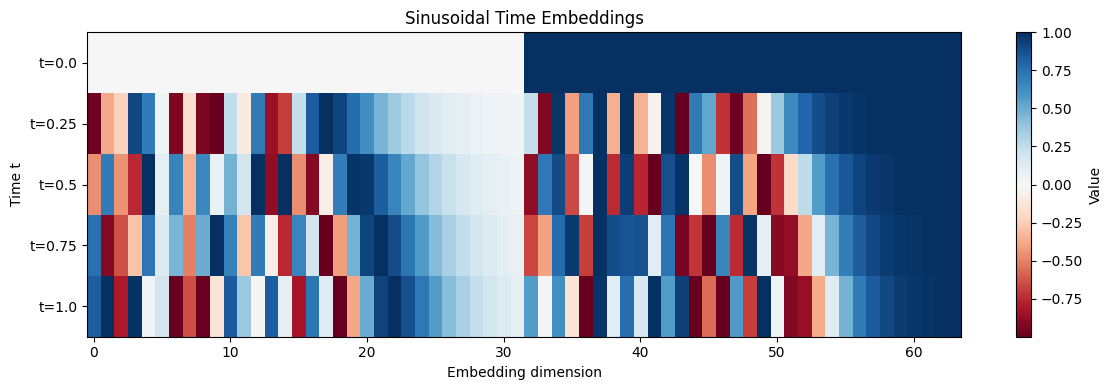

In [12]:
# Test
time_emb = SinusoidalTimeEmbedding(64)
t_test = torch.tensor([0.0, 0.25, 0.5, 0.75, 1.0])
emb = time_emb(t_test)
print(f"Time embedding shape: {emb.shape}")  # [5, 64]

# Visualize
plt.figure(figsize=(12, 4))
plt.imshow(emb.detach().numpy(), aspect='auto', cmap='RdBu')
plt.xlabel('Embedding dimension')
plt.ylabel('Time t')
plt.yticks(range(5), ['t=0.0', 't=0.25', 't=0.5', 't=0.75', 't=1.0'])
plt.colorbar(label='Value')
plt.title('Sinusoidal Time Embeddings')
plt.tight_layout()
plt.show()

In [12]:
%pip install torchtune torchao

Note: you may need to restart the kernel to use updated packages.


In [13]:
# MHA
from torchtune.modules import RotaryPositionalEmbeddings
# torchtune RopE implementation expects input shape [B, T, n_head, head_dim], matches the code below

class MHA(nn.Module):
    def __init__(self, n_embd, n_head, dropout=0.1):
        super().__init__()
        assert n_embd % n_head == 0

        self.n_head = n_head
        self.n_embd = n_embd
        self.head_dim = n_embd // n_head

        self.c_attn = nn.Linear(n_embd, 3*n_embd)
        self.c_proj = nn.Linear(n_embd, n_embd)

        self.rope = RotaryPositionalEmbeddings(dim=n_embd // n_head)

        self.attn_dropout = nn.Dropout(dropout)
        self.residual_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        # atten_c: [n_embd, 3*n_embd];
        # x: [B, T, n_embd];
        # attn_c(x): [B, T, n_embd]@[n_embd, 3*n_embd]=[B, T, 3*n_embd]
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2) # [B, T, 3*n_embd] ==> 3 * [B, T, n_embd]

        q = q.view(B, T, self.n_head, self.head_dim) # [B, T, n_embd] = [B, T, n_head*head_dim] ==> [B, T, n_head, head_dim]
        # apply RoPE before transpose
        q = self.rope(q)
        q = q.transpose(1, 2) # [B, n_head, T, head_dim]
        k = k.view(B, T, self.n_head, self.head_dim)
        k = self.rope(k)
        k = k.transpose(1, 2) # [B, n_head, T, head_dim]
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)

        # k.transpose(-2, -1).shape: [B, n_head, head_dim, T]
        # (q @ k.transpose(-2, -1)).shape: [B, n_head, T, head_dim]@[B, n_head, head_dim, T] = [B, n_head, T, T]
        attn = (q @ k.transpose(-2, -1)*(1.0 / math.sqrt(self.head_dim))) # [B, n_head, T, T]

        # No causal mask

        attn = F.softmax(attn, dim=-1)
        attn = self.attn_dropout(attn)

        out = attn @ v # [B, n_head, T, T]@[B, n_head, T, head_dim] = [B, n_head, T, head_dim]
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        # drop out on the residual stream
        out = self.residual_dropout(self.c_proj(out)) # [B, T, C]@[C, C]=[B, T, C]

        return out


Skipping import of cpp extensions due to incompatible torch version 2.8.0+cu128 for torchao version 0.14.1             Please see https://github.com/pytorch/ao/issues/2919 for more info


In [14]:
class SwiGLU(nn.Module):
    """
    SwiGLU activation function.

    This effectively implements:
    SwiGLU(x) = (xW + b) * SiLU(xV + c)

    Where the input is split into two parts: one for the 'value' path
    and one for the 'gate' path.
    """
    def forward(self, x):
        # Split the input tensor into two halves along the last dimension
        x, gate = x.chunk(2, dim=-1)
        # Apply SiLU (Swish) to the gate and multiply with the value
        return x * F.silu(gate)

In [15]:
# FFN

class FFN(nn.Module):
    def __init__(self, n_embd, dropout=0.1):
        super().__init__()
        self.c_fc = nn.Linear(n_embd, 8*n_embd)
        self.swiglu = SwiGLU()
        self.c_proj = nn.Linear(4*n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x) # [B, T, C]@[C, 4*C]=[B, T, 4*C]
        x = self.swiglu(x)
        x = self.c_proj(x) # [B, T, 4*C]@[4*C, C]=[B, T, C]
        x = self.dropout(x) # [B, T, C]

        return x

In [16]:
# Block

class Block(nn.Module):
    def __init__(self, n_embd, n_head, dropout=0.1, use_time=True):
        super().__init__()
        self.use_time = use_time
        self.rms_norm_1 = nn.RMSNorm(n_embd)
        self.rms_norm_2 = nn.RMSNorm(n_embd)
        self.attn = MHA(n_embd, n_head, dropout)
        self.ffn = FFN(n_embd, dropout)

        # RMSNorm is designed to be "shift-invariant" (it centers data around 0), in Diffusion models, injecting the shift (beta) back in after normalization is a powerful way to tell the network about the noise level
        if use_time:
            self.time_ffn = nn.Sequential(
                nn.Linear(n_embd, 2 * n_embd),
                SwiGLU(), # SwiGLU will half the feature dimension
                nn.Linear(n_embd, 4*n_embd)
            )

    def forward(self, x, time_emb=None):
        if self.use_time and time_emb is not None:
            time_params = self.time_ffn(time_emb) # [B, e_embd]@[n_embd, 4*n_embd]=[B, 4*n_embd]
            shift1, scale1, shift2, scale2 = time_params.chunk(4, dim=-1) # [B, n_embd]

            h = self.rms_norm_1(x) * (1 + scale1.unsqueeze(1)) + shift1.unsqueeze(1) # [B, T, C]*[B, 1, C]+[B, 1, C]=[B, T, C]
            x = x + self.attn(h)
            h = self.rms_norm_2(x) * (1 + scale2.unsqueeze(1)) + shift2.unsqueeze(1) # [B, T, C]*[B, 1, C]+[B, 1, C]=[B, T, C]
            x = x + self.ffn(h) # [B, T, C]
        else:
            x = x + self.attn(self.rms_norm_1(x))
            x = x + self.ffn(self.rms_norm_2(x))

        return x


In [17]:
# Full MDLM

class MDLM(nn.Module):
    def __init__(
            self,
            vocab_size,
            n_embd,
            n_head,
            n_block,
            block_size,
            dropout=0.1,
            use_time = True
    ):
        super().__init__()

        self.block_size = block_size
        self.use_time = use_time
        self.tok_emb = nn.Embedding(vocab_size, n_embd)
        if use_time:
            self.time_emb = SinusoidalTimeEmbedding(n_embd)
            self.time_proj = nn.Sequential(
                nn.Linear(n_embd, 2*n_embd),
                SwiGLU(),
                nn.Linear(n_embd, n_embd)
            )
        self.blocks = nn.ModuleList([
            Block(n_embd, n_head, dropout, use_time) for _ in range(n_block)
        ])

        self.rms_norm_final = nn.RMSNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)

        # tie input and output embedding weights
        self.lm_head.weight = self.tok_emb.weight

        self.dropout = nn.Dropout(dropout)
        self.apply(self._init_weights)

        n_params = sum(p.numel() for p in self.parameters())
        print(f'Model has {n_params/1e6:.2f}M parameters.')

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.RMSNorm):
            torch.nn.init.ones_(module.weight)

    def forward(self, x, t=None):
        B, T = x.shape

        tok_emb = self.tok_emb(x) # [B, T, n_embd]
        h = self.dropout(tok_emb)

        if self.use_time and t is not None:
            t_emb = self.time_emb(t) # [B, n_embd]
            t_emb = self.time_proj(t_emb) # [B, n_embd]
        else:
            t_emb = None

        for block in self.blocks:
            h = block(h, t_emb)

        h = self.rms_norm_final(h)
        logits = self.lm_head(h) # [B, T, V]

        # Make sure model doesn't learn the behavior of predicting a mask token. Aligns with inference
        logits[:, :, MASK_TOKEN] = float('-inf')

        return logits

In [18]:
# Instantiate model

model = MDLM(
    vocab_size=final_vocab_size,
    n_embd=n_embd,
    n_head=n_head,
    n_block=n_blocks,
    block_size=block_size,
).to(device)

Model has 39.65M parameters.


In [19]:
# training loop

from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

import os
import time

CKPT_DIR = './ckpt'
CKPT_PATH = os.path.join(CKPT_DIR, 'latest.pt')
os.makedirs(CKPT_DIR, exist_ok=True)

def train(model, dataloader, epochs, lr=3e-4, warmup_steps=1000, save_interval_minutes=20):
    """
    Training loop with bfloat16 AMP, auto-resume, periodic checkpointing,
    torch.compile, and optimized logging to minimize CPU-GPU synchronization.
    """

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    total_steps = len(dataloader) * epochs

    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        else:
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            return 0.5 * (1 + math.cos(math.pi * progress))

    scheduler = LambdaLR(optimizer, lr_lambda)

    # ============================================================
    # AUTO-RESUME: Check for existing checkpoint
    # ============================================================
    start_epoch = 0
    global_step = 0
    losses = []

    if os.path.exists(CKPT_PATH):
        print(f"📂 Found checkpoint at {CKPT_PATH}")
        checkpoint = torch.load(CKPT_PATH, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        global_step = checkpoint['global_step']
        losses = checkpoint['losses']
        print(f"✅ Resuming from epoch {start_epoch + 1}, step {global_step}")
    else:
        print("🆕 No checkpoint found, starting fresh")
    print("-" * 50)

    # ============================================================
    # SAVE CHECKPOINT FUNCTION
    # ============================================================
    def save_checkpoint(epoch, step):
        torch.save({
            'epoch': epoch,
            'global_step': step,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'losses': losses,
        }, CKPT_PATH)
        print(f"\n💾 Checkpoint saved at epoch {epoch + 1}, step {step}")

    # ============================================================
    # TRAINING LOOP
    # ============================================================
    model.train()
    device_type = device.type
    print(f"Training with bfloat16 on {device_type}")
    
    # 1. COMPILE MODEL (Huge speedup for small models on 5090)
    print("Compiling model...")
    model = torch.compile(model)
    print("Model compiled.")

    last_save_time = time.time()
    
    for epoch in range(start_epoch, epochs):
        torch.cuda.reset_peak_memory_stats()
        
        # We will track epoch loss by accumulating locally
        running_loss_sum = 0.0
        running_steps = 0
        
        pbar = tqdm(dataloader, desc=f'Epoch {epoch + 1}/{epochs}')
        
        for batch_idx, batch in enumerate(pbar):
            x_0 = batch.to(device)

            with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                loss = compute_loss(model, x_0, MASK_TOKEN)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
            global_step += 1

            # OPTIMIZED LOGGING: Only sync to CPU every 20 steps
            if batch_idx % 20 == 0:
                # This .item() forces a sync, but doing it 1/20th as often
                # frees the GPU to run ahead.
                current_loss = loss.item()
                losses.append(current_loss)
                
                # Update progress bar
                pbar.set_postfix({
                    'loss': f'{current_loss:.4f}',
                    'lr': f'{scheduler.get_last_lr()[0]:.2e}'
                })
                
                # Accumulate for average
                running_loss_sum += current_loss
                running_steps += 1
            
            # === AUTOSAVE EVERY N MINUTES ===
            if (time.time() - last_save_time) / 60 >= save_interval_minutes:
                save_checkpoint(epoch, global_step)
                last_save_time = time.time()

        # End of Epoch Stats
        avg_loss = running_loss_sum / max(1, running_steps)
        max_allocated = torch.cuda.max_memory_allocated(0) / 1024**3
        max_reserved = torch.cuda.max_memory_reserved(0) / 1024**3
        
        print(f"Epoch {epoch + 1} average loss (sampled): {avg_loss:.4f}")
        print(f"Max VRAM Usage: {max_allocated:.2f} GB allocated / {max_reserved:.2f} GB reserved")

    save_checkpoint(epochs - 1, global_step)
    print("✅ Training complete!")

    return losses

In [20]:
# start training

losses = train(model, dataloader, epochs=100, lr=3e-4)

🆕 No checkpoint found, starting fresh
--------------------------------------------------
Training with bfloat16 on cuda
Compiling model...
Model compiled.


Epoch 1/100: 100%|██████████| 157/157 [00:23<00:00,  6.61it/s, loss=4.7890, lr=4.23e-05]


Epoch 1 average loss (sampled): 5.9168
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 2/100: 100%|██████████| 157/157 [00:19<00:00,  7.94it/s, loss=4.1330, lr=8.94e-05]


Epoch 2 average loss (sampled): 4.3498
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 3/100: 100%|██████████| 157/157 [00:19<00:00,  7.93it/s, loss=3.9049, lr=1.36e-04]


Epoch 3 average loss (sampled): 3.9672
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 4/100: 100%|██████████| 157/157 [00:19<00:00,  7.92it/s, loss=3.5587, lr=1.84e-04]


Epoch 4 average loss (sampled): 3.6240
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 5/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=3.2958, lr=2.31e-04]


Epoch 5 average loss (sampled): 3.3745
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 6/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=3.1947, lr=2.78e-04]


Epoch 6 average loss (sampled): 3.1788
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 7/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.8961, lr=3.00e-04]


Epoch 7 average loss (sampled): 3.0451
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 8/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.8610, lr=3.00e-04]


Epoch 8 average loss (sampled): 2.9616
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 9/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.9079, lr=2.99e-04]


Epoch 9 average loss (sampled): 2.9090
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 10/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.8642, lr=2.99e-04]


Epoch 10 average loss (sampled): 2.8422
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 11/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.7816, lr=2.98e-04]


Epoch 11 average loss (sampled): 2.7888
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 12/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.7598, lr=2.97e-04]


Epoch 12 average loss (sampled): 2.7981
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 13/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.6264, lr=2.96e-04]


Epoch 13 average loss (sampled): 2.6899
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 14/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.5714, lr=2.95e-04]


Epoch 14 average loss (sampled): 2.6762
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 15/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.6851, lr=2.94e-04]


Epoch 15 average loss (sampled): 2.6023
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 16/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.5698, lr=2.92e-04]


Epoch 16 average loss (sampled): 2.5534
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 17/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=2.5052, lr=2.91e-04]


Epoch 17 average loss (sampled): 2.5504
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 18/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.6152, lr=2.89e-04]


Epoch 18 average loss (sampled): 2.5029
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 19/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.5058, lr=2.87e-04]


Epoch 19 average loss (sampled): 2.4964
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 20/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=2.4212, lr=2.85e-04]


Epoch 20 average loss (sampled): 2.4973
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 21/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.4055, lr=2.83e-04]


Epoch 21 average loss (sampled): 2.4726
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 22/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.6085, lr=2.80e-04]


Epoch 22 average loss (sampled): 2.5012
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 23/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=2.5381, lr=2.78e-04]


Epoch 23 average loss (sampled): 2.4038
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 24/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.3807, lr=2.75e-04]


Epoch 24 average loss (sampled): 2.4028
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 25/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=2.2216, lr=2.72e-04]


Epoch 25 average loss (sampled): 2.3670
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 26/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=2.3828, lr=2.69e-04]


Epoch 26 average loss (sampled): 2.3982
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 27/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.4176, lr=2.66e-04]


Epoch 27 average loss (sampled): 2.3573
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 28/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=2.2194, lr=2.63e-04]


Epoch 28 average loss (sampled): 2.3312
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 29/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.3338, lr=2.59e-04]


Epoch 29 average loss (sampled): 2.3579
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 30/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=2.3314, lr=2.56e-04]


Epoch 30 average loss (sampled): 2.2602
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 31/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=2.1751, lr=2.52e-04]


Epoch 31 average loss (sampled): 2.3085
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 32/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.3095, lr=2.48e-04]


Epoch 32 average loss (sampled): 2.3217
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 33/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.3474, lr=2.44e-04]


Epoch 33 average loss (sampled): 2.2964
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 34/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.3307, lr=2.40e-04]


Epoch 34 average loss (sampled): 2.3125
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 35/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.3160, lr=2.36e-04]


Epoch 35 average loss (sampled): 2.2696
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 36/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=2.2506, lr=2.32e-04]


Epoch 36 average loss (sampled): 2.2280
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 37/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.0732, lr=2.28e-04]


Epoch 37 average loss (sampled): 2.2452
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 38/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.1856, lr=2.24e-04]


Epoch 38 average loss (sampled): 2.1487
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 39/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.1617, lr=2.19e-04]


Epoch 39 average loss (sampled): 2.2200
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 40/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.3409, lr=2.15e-04]


Epoch 40 average loss (sampled): 2.2352
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 41/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=2.1772, lr=2.10e-04]


Epoch 41 average loss (sampled): 2.1808
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 42/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=2.0946, lr=2.05e-04]


Epoch 42 average loss (sampled): 2.1833
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 43/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.1804, lr=2.01e-04]


Epoch 43 average loss (sampled): 2.1303
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 44/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.1615, lr=1.96e-04]


Epoch 44 average loss (sampled): 2.1200
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 45/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.0627, lr=1.91e-04]


Epoch 45 average loss (sampled): 2.1005
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 46/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.0695, lr=1.86e-04]


Epoch 46 average loss (sampled): 2.2021
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 47/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.2731, lr=1.81e-04]


Epoch 47 average loss (sampled): 2.1835
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 48/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.0933, lr=1.76e-04]


Epoch 48 average loss (sampled): 2.1466
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 49/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.1480, lr=1.72e-04]


Epoch 49 average loss (sampled): 2.1122
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 50/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.2300, lr=1.67e-04]


Epoch 50 average loss (sampled): 2.1563
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 51/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=1.9901, lr=1.61e-04]


Epoch 51 average loss (sampled): 2.0924
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 52/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.0937, lr=1.56e-04]


Epoch 52 average loss (sampled): 2.1362
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 53/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.1233, lr=1.51e-04]


Epoch 53 average loss (sampled): 2.0759
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 54/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=2.0944, lr=1.46e-04]


Epoch 54 average loss (sampled): 2.0996
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 55/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.1394, lr=1.41e-04]


Epoch 55 average loss (sampled): 2.0170
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 56/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=2.2351, lr=1.36e-04]


Epoch 56 average loss (sampled): 2.0843
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 57/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=1.8913, lr=1.31e-04]


Epoch 57 average loss (sampled): 2.0583
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 58/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=2.1807, lr=1.26e-04]


Epoch 58 average loss (sampled): 2.0865
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 59/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=2.1431, lr=1.21e-04]


Epoch 59 average loss (sampled): 2.0726
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 60/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.4299, lr=1.16e-04]


Epoch 60 average loss (sampled): 2.1097
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 61/100:  25%|██▍       | 39/157 [00:06<01:07,  1.75it/s, loss=2.2055, lr=1.15e-04]


💾 Checkpoint saved at epoch 61, step 9459


Epoch 61/100: 100%|██████████| 157/157 [00:21<00:00,  7.40it/s, loss=1.9380, lr=1.12e-04]


Epoch 61 average loss (sampled): 2.0548
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 62/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.2155, lr=1.07e-04]


Epoch 62 average loss (sampled): 2.0831
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 63/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=1.9202, lr=1.02e-04]


Epoch 63 average loss (sampled): 1.9770
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 64/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=1.9120, lr=9.72e-05]


Epoch 64 average loss (sampled): 2.0023
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 65/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.0697, lr=9.26e-05]


Epoch 65 average loss (sampled): 2.0543
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 66/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=1.9768, lr=8.79e-05]


Epoch 66 average loss (sampled): 1.9940
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 67/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=1.9461, lr=8.34e-05]


Epoch 67 average loss (sampled): 1.9525
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 68/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.0688, lr=7.89e-05]


Epoch 68 average loss (sampled): 1.9594
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 69/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.0635, lr=7.45e-05]


Epoch 69 average loss (sampled): 1.9828
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 70/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=1.8576, lr=7.02e-05]


Epoch 70 average loss (sampled): 1.9635
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 71/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=1.8856, lr=6.60e-05]


Epoch 71 average loss (sampled): 1.9954
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 72/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=2.0275, lr=6.19e-05]


Epoch 72 average loss (sampled): 1.9926
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 73/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=1.9979, lr=5.79e-05]


Epoch 73 average loss (sampled): 2.0028
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 74/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=1.9868, lr=5.39e-05]


Epoch 74 average loss (sampled): 1.9969
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 75/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.0535, lr=5.01e-05]


Epoch 75 average loss (sampled): 1.9784
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 76/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=2.1136, lr=4.64e-05]


Epoch 76 average loss (sampled): 1.9938
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 77/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.0250, lr=4.29e-05]


Epoch 77 average loss (sampled): 1.9053
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 78/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.0625, lr=3.94e-05]


Epoch 78 average loss (sampled): 1.8859
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 79/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=1.7550, lr=3.61e-05]


Epoch 79 average loss (sampled): 1.9130
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 80/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=1.9181, lr=3.28e-05]


Epoch 80 average loss (sampled): 1.9025
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 81/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=1.9630, lr=2.98e-05]


Epoch 81 average loss (sampled): 1.9060
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 82/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=2.0695, lr=2.68e-05]


Epoch 82 average loss (sampled): 1.9778
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 83/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=1.9538, lr=2.40e-05]


Epoch 83 average loss (sampled): 1.9612
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 84/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=2.0612, lr=2.14e-05]


Epoch 84 average loss (sampled): 1.9221
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 85/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=2.1579, lr=1.88e-05]


Epoch 85 average loss (sampled): 1.9228
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 86/100: 100%|██████████| 157/157 [00:19<00:00,  7.91it/s, loss=1.9228, lr=1.65e-05]


Epoch 86 average loss (sampled): 1.9382
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 87/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=2.0568, lr=1.43e-05]


Epoch 87 average loss (sampled): 1.8817
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 88/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=1.8105, lr=1.22e-05]


Epoch 88 average loss (sampled): 1.8842
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 89/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=1.7718, lr=1.03e-05]


Epoch 89 average loss (sampled): 1.8816
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 90/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=1.8815, lr=8.53e-06]


Epoch 90 average loss (sampled): 1.9264
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 91/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=1.9095, lr=6.94e-06]


Epoch 91 average loss (sampled): 1.9130
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 92/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=2.1005, lr=5.51e-06]


Epoch 92 average loss (sampled): 1.9133
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 93/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=1.9680, lr=4.24e-06]


Epoch 93 average loss (sampled): 1.8433
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 94/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=1.9837, lr=3.13e-06]


Epoch 94 average loss (sampled): 1.8577
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 95/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=1.7629, lr=2.19e-06]


Epoch 95 average loss (sampled): 1.8971
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 96/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=1.9010, lr=1.42e-06]


Epoch 96 average loss (sampled): 1.9064
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 97/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=1.8184, lr=8.12e-07]


Epoch 97 average loss (sampled): 1.9565
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 98/100: 100%|██████████| 157/157 [00:19<00:00,  7.87it/s, loss=1.9939, lr=3.73e-07]


Epoch 98 average loss (sampled): 1.9266
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 99/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=1.9706, lr=1.03e-07]


Epoch 99 average loss (sampled): 1.9205
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved


Epoch 100/100: 100%|██████████| 157/157 [00:19<00:00,  7.90it/s, loss=1.8659, lr=8.77e-10]


Epoch 100 average loss (sampled): 1.9156
Max VRAM Usage: 18.17 GB allocated / 20.94 GB reserved

💾 Checkpoint saved at epoch 100, step 15700
✅ Training complete!


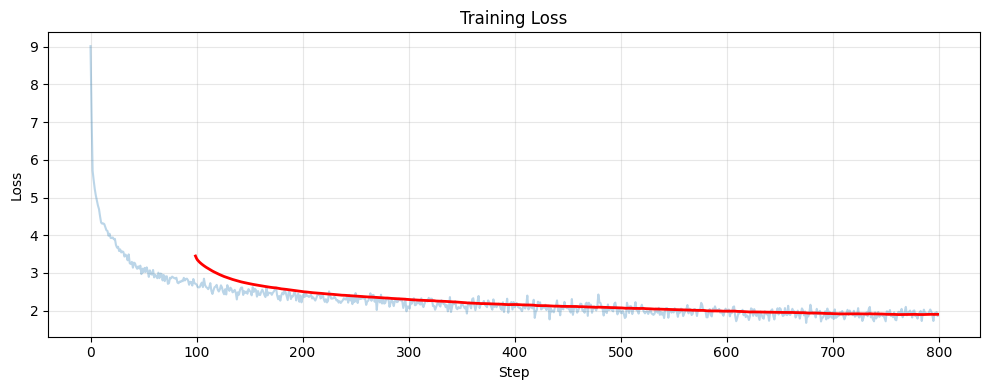

In [21]:
# Plot loss curve
plt.figure(figsize=(10, 4))
plt.plot(losses, alpha=0.3)
# Smoothed
window = 100
smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(losses)), smoothed, 'r', linewidth=2)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()